In [ ]:
!pip install transformers
!pip install accelerate
!pip install datasets
!pip install optuna



> Making Transformer Efficient:
 -  If our transformer model is large and does not meet production environment requirement then we failed at building best model.
 -  An obvious alternative is to train a faster and more compact model, but the
reduction in model capacity is often accompanied by a degradation in performance.
 - 4 techniques to increase models inference time, decrease memory footprint and make effcient are
    - Knowledge distillation
    - Quantization
    - Pruning
    - Graph Optimization
 - Experiment have shown that combination of above methods has improved latency of BERT by factor of 30

- In this Chapter we look it through case study of Intent Classification, where model classifies input text from user to in-house scope of intent i.e. intent is present in as defined classes or query is relevant and it also predicts out of scope if intent is not related to pre-defined classes.

  - We are working on CLINIC150 dataset and BERT base model that is finetuned on it. Dataset also consists 1200 out of scope quereis that belong to oos intent
   






In [1]:
from transformers import pipeline
from datasets import load_dataset
# from datasets import load_metric
import evaluate
from pathlib import Path
from time import perf_counter

import torch
import numpy as np

In [2]:
bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification",model=bert_ckpt)

In [3]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490036010742188}]

> Creating a Performance Benchmark
  - Three major constraint for deploying a model into production are
      - Model Performance : How well does it perform on test set which refelcts production data?
      - Latency : How fast does model deilver predictions?
      - Memory Footprint : How can we deploy large model like T5,GPT-2 which require lot of RAM?
  - If these constraints are not addressed then our end user will expreience negative impact.


In [4]:
#Abstrat Class to measure performance of any pipeline
class PerformanceBenchmark:

    def __init__(self,pipeline,dataset,optim_type = "BERT baseline"):

        self.pipeline = pipeline
        self.dataset  = dataset
        self.optim_type = optim_type


    def compute_accuracy(self):
        #method to compute the accuracy.....
        preds , labels = [], []

        for example in self.dataset:
            prediction = self.pipeline(example['text'])[0]['label']
            prediction = intents.str2int(prediction)
            preds.append(prediction)
            labels.append(example['intent'])
            acc_ = accuracy_score.compute(predictions = preds, references = labels)
        print(f"Accuracy on test set - {acc_['accuracy']:.3f}")
        return acc_

    def compute_size(self):
        # We compute size of model by saving it to disk and compute file sizes
        state_dict = self.pipeline.model.state_dict()
        tmp_path = Path("model.pt")
        torch.save(state_dict, tmp_path)
        # Calculate size in megabytes
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        # Delete temporary file
        tmp_path.unlink()
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}


    def time_pipeline(self,query="What is the pin number for my account?"):
        # We'll using perf_counter method from time to calculate time for qery to get answer from pipeline
        latencies = []
        for _ in range(10):
            _ = self.pipeline(query)

        for _ in range(100):
            start = perf_counter()
            __ = self.pipeline(query)
            lat = perf_counter() - start
            latencies.append(lat)

        avg_ = 1000 * np.mean(latencies)
        std_ = 1000 * np.std(latencies)

        print(f"Average latency(ms) - {avg_:.2f} +/- {std_:.2f} ")
        return {"time_avg_ms": avg_, "time_std_ms": std_}

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

#accuracy_score
# accuracy_score = load_metric('accuracy')
accuracy_score = evaluate.load('accuracy')

In [5]:
#trying to calculate accuracy of pipeline using test set.....
clinc = load_dataset("clinc_oos","plus")

In [6]:
#seeing a sample of dataset...
sample = clinc["test"][45]
sample

{'text': 'transfer seventeen dollars from rbs to woodforest account, please',
 'intent': 133}

In [7]:
intents = clinc['test'].features['intent']
intents.int2str(sample['intent'])

'transfer'

In [30]:
#performance becnhmark on clinc dataset...
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pd.run_benchmark()
# perf_metrics.update(pb.run_benchmark())

Model size (MB) - 418.15
Average latency(ms) - 78.64 +/- 4.44 
Accuracy on test set - 0.867


In [31]:
perf_metrics

{'DistillBERT': {'size_mb': 255.88143634796143,
  'time_avg_ms': 39.39732400001958,
  'time_std_ms': 0.5742511502934915,
  'accuracy': 0.8592727272727273},
 'BERT baseline': {'size_mb': 418.14669132232666,
  'time_avg_ms': 78.642221998889,
  'time_std_ms': 4.439266224251055,
  'accuracy': 0.8672727272727273}}

### Knowledge Distillation
- It is a general purpose method for training a smaller *student* model to mimic the behaviour of slower,larger but better performing *teacher* model.
- We train a student model by softening model probabilities of teacher output so that student model tries to mimic it.
  -  We soften the probabilites of teacher model by T temperature so that it reveals more information about decision boundaries that teacher has learned.
    - p(x) = exp(z(x)/T) / Sum(exp(z(x)/T))
  - Student also produces probs dist q(x)
  then we calculate KL-Divergence between them to measure difference between them
    - D_kl(p,q) = SUM(pi(x_)log(pi(x)/qi(x))
 - Now we approximate prob dist of teacher with student by defining KD loss
   - L_kd = T^2D_kl
   - T^2 normalizing factor for gradinets produced by softlabel scales
 - Now final loss L_student
    - L_stu = alpha*L_ce + (1-alpha)*L_kd
    - L_ce : cross entropy loss of student in classification task
    - alpha : controls relative strength of both losses.

- We should pick a smaller model for student to reduce latency and memory footprint
- Rule of thumb from literature is that distillation works best when teacher and student are from same *model type*

  

In [1]:
import transformers; transformers.__version__

'4.34.1'

In [9]:
from transformers import TrainingArguments
from transformers import Trainer
from transformers import AutoTokenizer
from transformers import AutoConfig,AutoModelForSequenceClassification
from huggingface_hub import notebook_login

import torch.nn as nn
import torch.nn.functional as F

In [10]:
#class for creating arguments for distillation task
class DistillationTrainingArguments(TrainingArguments):    
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs): 
        super().__init__(*args,**kwargs)
        self.alpha = alpha
        self.temperature = temperature
        
#Trainer class for distillation with overring compute_loss() as required for distillation loss function
class DistillationTrainer(Trainer):
    def __init__(self,*args,teacher_model=None,**kwargs):
        super().__init__(*args,**kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self,model,inputs,return_outputs=False):

        #extracting outputs from student model
        outputs_stu = model(**inputs)

        #cross_entropy loss and logits from student model
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits

        #extract logits from teacher model
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea  = outputs_tea.logits

        #Soften probabilities and compute KLDiv loss
        loss_kl_fun = nn.KLDivLoss(reduction="batchmean")
        loss_kd     = self.args.temperature**2*loss_kl_fun(
                      F.log_softmax(logits_stu/self.args.temperature,dim=-1), #smoothing probs of student model
                      F.softmax(logits_tea/self.args.temperature,dim=-1) #smoothing probs of teacher model
                       )
        #final loss
        loss = self.args.alpha * loss_ce + (1 - self.args.alpha) * loss_kd

        return (loss,outputs_stu) if return_outputs else loss

#function to compute metrics....
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

In [11]:
notebook_login()

In [12]:
#tokenzing text and creating dataset of tokenizers...
student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

In [13]:
#defining the training arguments......
batch_size = 48
finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"

student_training_args = DistillationTrainingArguments(output_dir=finetuned_ckpt,
                                                      evaluation_strategy = "epoch",
                                                      num_train_epochs=5,
                                                      learning_rate=2e-5,
                                                      per_device_train_batch_size=batch_size,
                                                      per_device_eval_batch_size=batch_size,
                                                      alpha = 1,
                                                      weight_decay=0.01,
                                                      push_to_hub = True,
                                                      logging_strategy="epoch",
                                                      load_best_model_at_end = True,
                                                      save_strategy = "epoch",
                                                      )

In [14]:
#writing config file to map labels from int to str or str to int
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [15]:
#defining config class and student,teacher models....
num_labels = intents.num_classes
student_config = AutoConfig.from_pretrained(student_ckpt,num_labels=num_labels,
                            id2label=id2label,label2id=label2id)

In [16]:
#init function so that new studnet model get initiated whenever new trainer is called
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def student_init():
    return AutoModelForSequenceClassification.from_pretrained(student_ckpt,config=student_config).to(device)


In [17]:
#defining the teacher model....
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = AutoModelForSequenceClassification.from_pretrained(teacher_ckpt,num_labels=num_labels).to(device)


In [18]:
#Trainer for distillation
dsbert_trainer = DistillationTrainer(model_init=student_init,
                                     teacher_model = teacher_model,
                                     args = student_training_args,
                                     train_dataset = clinc_enc['train'],
                                     eval_dataset  = clinc_enc['validation'],
                                     compute_metrics = compute_metrics,
                                     tokenizer = student_tokenizer,)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
dsbert_trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,4.274600,3.261815,0.717097
2,2.600800,1.860147,0.835161
3,1.532000,1.151079,0.895161
4,1.005000,0.854258,0.913548
5,0.792100,0.773312,0.918710


TrainOutput(global_step=1590, training_loss=2.040919715353528, metrics={'train_runtime': 845.8662, 'train_samples_per_second': 90.144, 'train_steps_per_second': 1.88, 'total_flos': 413013830824140.0, 'train_loss': 2.040919715353528, 'epoch': 5.0})

In [20]:
dsbert_trainer.push_to_hub("Training Completed")

'https://huggingface.co/gouse-73/distilbert-base-uncased-finetuned-clinc/tree/main/'

In [21]:
finetuned_ckpt = "gouse-73/distilbert-base-uncased-finetuned-clinc"
tuned_pipe = pipeline("text-classification",model=finetuned_ckpt)

D:\Conda3\Lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Demo\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 78ddea51-8922-460e-80c5-bbc0b59a8ff4)')'

In [24]:
pb = PerformanceBenchmark(tuned_pipe,clinc['test'],optim_type="DistillBERT")
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency(ms) - 39.40 +/- 0.57 
Accuracy on test set - 0.859


In [25]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(perf_metrics,current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics,orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]

        if idx == current_optim_type:
            plt.scatter(df_opt['time_avg_ms'],df_opt['accuracy']*100,
                      alpha=.5,s=df_opt['size_mb'],label=idx,
                      marker='$\u25CC$')
        else:
            plt.scatter(df_opt['time_avg_ms'],df_opt['accuracy']*100,
                      alpha=.5,s=df_opt['size_mb'],label=idx,)

    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legend_handles:
        handle.set_sizes([20])

    plt.ylim(80,90)

    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 50)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

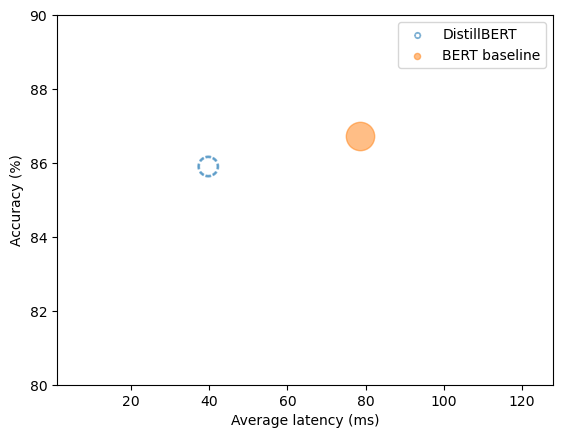

In [32]:
plot_metrics(perf_metrics,"DistillBERT")

Finding Good Hyperparameters with Optuna
- Framework defined for finding good values for hyperparameters by performing search

In [27]:
#we deifine an objective method that return function we want to minimize
def objective(trail):
    x = trail.suggest_float("x",-2,2)
    y = trail.suggest_float("y",-2,2)

    return (1-x)**2 + 100*(y-x**2)**2

In [33]:
import optuna

study = optuna.create_study()
study.optimize(objective,n_trials=1000)

In [ ]:
study.best_params

{'x': 0.9797947131291717, 'y': 0.9607110817777572}

In [34]:
#defing hyper-parameter space....
def hp_space(trial):
    return {"num_train_epochs" : trial.suggest_int("num_train_epochs",5,10),
          "alpha" : trial.suggest_float("alpha",0,1),
          "temperature" : trial.suggest_int("temperature",2,20)}

In [35]:
#running hp_space on trainer
best_run = dsbert_trainer.hyperparameter_search(n_trials=20,
                                                direction="maximize",
                                                hp_space=hp_space)

[I 2023-10-25 16:08:31,735] A new study created in memory with name: no-name-21705f7c-43d5-4c63-82c8-0bf739370c0e
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unc

Epoch,Training Loss,Validation Loss,Accuracy
1,0.396300,0.208424,0.566129
2,0.178300,0.108130,0.809677
3,0.116300,0.077325,0.868065
4,0.093600,0.064682,0.888387
5,0.084700,0.061168,0.891935


[I 2023-10-25 16:26:08,777] Trial 0 finished with value: 0.8919354838709678 and parameters: {'num_train_epochs': 5, 'alpha': 0.4160916619307726, 'temperature': 13}. Best is trial 0 with value: 0.8919354838709678.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Distil

Epoch,Training Loss,Validation Loss,Accuracy
1,0.427500,0.222743,0.600968


[I 2023-10-25 17:08:06,191] Trial 2 finished with value: 0.9225806451612903 and parameters: {'num_train_epochs': 10, 'alpha': 0.8293330413285169, 'temperature': 19}. Best is trial 2 with value: 0.9225806451612903.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Disti

Epoch,Training Loss,Validation Loss,Accuracy
1,0.387100,0.203309,0.563548
2,0.174200,0.106051,0.807742
3,0.114200,0.076280,0.868065
4,0.092100,0.063993,0.885484
5,0.083500,0.060586,0.890968


[I 2023-10-25 17:17:31,604] Trial 3 finished with value: 0.8909677419354839 and parameters: {'num_train_epochs': 5, 'alpha': 0.3851295409919169, 'temperature': 18}. Best is trial 2 with value: 0.9225806451612903.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Distil

Epoch,Training Loss,Validation Loss,Accuracy
1,0.573500,0.295599,0.655161
2,0.236300,0.122356,0.837742
3,0.128300,0.070661,0.899032
4,0.089200,0.051416,0.909677
5,0.071600,0.041807,0.918065
6,0.062300,0.037915,0.921290
7,0.057200,0.034939,0.923871
8,0.054800,0.034078,0.923548


[I 2023-10-25 17:32:36,130] Trial 4 finished with value: 0.9235483870967742 and parameters: {'num_train_epochs': 8, 'alpha': 0.9392408059053425, 'temperature': 3}. Best is trial 4 with value: 0.9235483870967742.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilB

Epoch,Training Loss,Validation Loss,Accuracy
1,0.811100,0.434685,0.662903
2,0.343800,0.176074,0.811935


[I 2023-10-25 17:36:15,345] Trial 5 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.b

Epoch,Training Loss,Validation Loss,Accuracy
1,0.424600,0.216908,0.610968
2,0.180000,0.101490,0.839032
3,0.108300,0.065661,0.899032
4,0.079900,0.049009,0.905161
5,0.065500,0.040150,0.915161
6,0.057000,0.035866,0.917419
7,0.051800,0.032490,0.920645


[I 2023-10-25 17:49:11,132] Trial 6 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.b

Epoch,Training Loss,Validation Loss,Accuracy
1,0.386700,0.197827,0.581935


[I 2023-10-25 17:51:02,118] Trial 7 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.b

Epoch,Training Loss,Validation Loss,Accuracy
1,0.425300,0.218296,0.607419
2,0.181700,0.103277,0.835161
3,0.110300,0.067516,0.894516
4,0.082200,0.051063,0.904194
5,0.068100,0.042380,0.911935
6,0.059900,0.038327,0.915161


[I 2023-10-25 18:02:09,572] Trial 8 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.b

Epoch,Training Loss,Validation Loss,Accuracy
1,0.386100,0.196708,0.586452
2,0.164700,0.095124,0.834516
3,0.101700,0.063718,0.890968
4,0.076400,0.048441,0.902581
5,0.063400,0.040211,0.913548
6,0.055400,0.036048,0.915161


[I 2023-10-25 18:40:57,315] Trial 9 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.b

Epoch,Training Loss,Validation Loss,Accuracy
1,0.803600,0.419297,0.667097
2,0.322800,0.153833,0.828710
3,0.155000,0.079968,0.897742
4,0.101100,0.058077,0.909355
5,0.080300,0.048342,0.920000
6,0.070700,0.044894,0.920000
7,0.066300,0.043137,0.920645


[I 2023-10-25 18:55:11,287] Trial 10 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.

Epoch,Training Loss,Validation Loss,Accuracy
1,0.398000,0.201985,0.597742
2,0.168400,0.095905,0.837097
3,0.102500,0.063135,0.895806
4,0.076000,0.047231,0.904839
5,0.062300,0.038683,0.914516
6,0.054000,0.034348,0.917742
7,0.048800,0.030814,0.919032


[I 2023-10-25 19:09:41,696] Trial 11 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.

Epoch,Training Loss,Validation Loss,Accuracy
1,0.380700,0.193163,0.583871


[I 2023-10-25 19:11:46,135] Trial 12 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.

Epoch,Training Loss,Validation Loss,Accuracy
1,0.398400,0.203070,0.595806
2,0.169600,0.097231,0.833548
3,0.103900,0.064451,0.893548
4,0.077600,0.048663,0.903226
5,0.064100,0.040245,0.913548
6,0.056000,0.036010,0.916774
7,0.051100,0.032717,0.919355


[I 2023-10-25 19:26:26,991] Trial 13 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.

Epoch,Training Loss,Validation Loss,Accuracy
1,0.461100,0.238558,0.620323
2,0.197800,0.111322,0.832581
3,0.118600,0.071604,0.894516
4,0.088000,0.054322,0.904516
5,0.073300,0.045632,0.912581
6,0.065400,0.042059,0.913548


[I 2023-10-25 19:39:04,034] Trial 14 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.

Epoch,Training Loss,Validation Loss,Accuracy
1,0.389300,0.197458,0.592581
2,0.164900,0.094420,0.835806
3,0.100900,0.062652,0.893871
4,0.075200,0.047074,0.903548
5,0.061800,0.038684,0.915161
6,0.053600,0.034398,0.918065
7,0.048500,0.030882,0.919677


[I 2023-10-25 19:53:44,840] Trial 15 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.

Epoch,Training Loss,Validation Loss,Accuracy
1,0.403300,0.206742,0.597419
2,0.173000,0.099665,0.833548
3,0.106600,0.066418,0.890968
4,0.080200,0.050705,0.901935
5,0.066900,0.042409,0.911613
6,0.059000,0.038430,0.914194


[I 2023-10-25 20:06:17,985] Trial 16 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.

Epoch,Training Loss,Validation Loss,Accuracy
1,0.381300,0.194000,0.580968


[I 2023-10-25 20:08:09,218] Trial 17 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.

Epoch,Training Loss,Validation Loss,Accuracy
1,0.499200,0.261312,0.628710
2,0.216100,0.121157,0.827742
3,0.128800,0.077460,0.888065
4,0.096000,0.059484,0.900968
5,0.081300,0.051673,0.910000
6,0.074700,0.049303,0.910645


[I 2023-10-25 20:19:23,351] Trial 18 pruned. 
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.

Epoch,Training Loss,Validation Loss,Accuracy
1,0.409600,0.211400,0.596774
2,0.177500,0.103014,0.829677
3,0.110200,0.069195,0.888387
4,0.083800,0.053658,0.900323
5,0.070800,0.045738,0.910645
6,0.063600,0.042320,0.911613


[I 2023-10-25 20:30:42,110] Trial 19 pruned. 


In [36]:
print(best_run)

BestRun(run_id='4', objective=0.9235483870967742, hyperparameters={'num_train_epochs': 8, 'alpha': 0.9392408059053425, 'temperature': 3}, run_summary=None)


In [ ]:
# !rm -r /content/distilbert-base-uncased-finetuned-clinc/run-13

In [37]:
#setting best HP values as training arguments....
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args,k,v)

#makeup
# for k,v in {'num_train_epochs': 10, 'alpha': 0.008040352679888452, 'temperature': 7}.items():
#     setattr(student_training_args,k,v)

In [38]:
# Define a new repository to store our distilled model
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt
student_training_args.push_to_hub = True

In [39]:
# Create a new Trainer with optimal parameters
distil_trainer = DistillationTrainer(model_init=student_init,
                                     teacher_model=teacher_model,
                                     args=student_training_args,
                                     train_dataset=clinc_enc['train'],
                                     eval_dataset=clinc_enc['validation'],compute_metrics=compute_metrics,
                                     tokenizer=student_tokenizer)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.we

In [40]:
distil_trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.we

Epoch,Training Loss,Validation Loss,Accuracy
1,4.034100,3.022955,0.724516
2,2.326600,1.559682,0.849355
3,1.195800,0.831609,0.914194
4,0.639600,0.528657,0.933226
5,0.386500,0.408728,0.936452
6,0.267900,0.351858,0.940645
7,0.211800,0.331291,0.941613
8,0.187400,0.323815,0.943871


TrainOutput(global_step=2544, training_loss=1.1562169437888283, metrics={'train_runtime': 935.2817, 'train_samples_per_second': 130.442, 'train_steps_per_second': 2.72, 'total_flos': 661045743216012.0, 'train_loss': 1.1562169437888283, 'epoch': 8.0})

In [41]:
distil_trainer.push_to_hub("Distillation Completed!!!")

'https://huggingface.co/gouse-73/distilbert-base-uncased-distilled-clinc/tree/main/'

In [42]:
#benchmarking distilled model......
distilled_ckpt = "gouse-73/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)

optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency(ms) - 21.31 +/- 1.84 
Accuracy on test set - 0.881


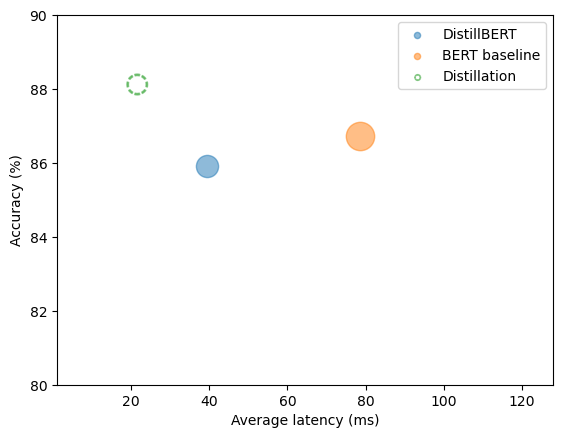

In [43]:
plot_metrics(perf_metrics, optim_type)

### Making Models Faster with Quantization
- It converts the weights and activations to low-precision data types like INT-8 from FP32(32-bit) values, by this less memory is required to store model and faster computations are done
- These can be acheived with no loss in accuracy
- Idea is to discretize floating values into smaller fixed point values
  - f = ((f_max - f_min)/(q_max-q_min))*(q-z) = S*(q-z)
  - q : low bits space we are trying to quantize
  - z : zero point where it represent floting point 0 in quantized domain
  - values surpasing q range are clamped down to q range

- Why they are suitable for transformer models?
  - bcz weights and activations tend to take values in relatively smaller ranges.

- From above eq q = f/S + Z

- In full scale transformers, compression rate depends on which layers are quantized (generally we quantize only the linear layers)

- 3 approaches of Quantization:
    - Dynamic Qunat : weights and activations of model get quantized on fly during inference time
      - since we are quantizing activations so they are written and read to memory as floting points
      - this conversion between integer and floating point can have effect on performance
      - this technique is simplest and widely used in NLP tasks

    - Static Quant :  instead of computing quants of activations on fly, we can avoid them by having pre-computed quantization scheme
      - this scheme is acheived by observing activation patterns on representative data ahead of inference time
      - this adds additional step between training and inference inorder to learn quantization scheme so this may lead to peformance bottleneck

    - Quantization-aware training: effect of quantization is simulated during training by "fake" quantization of FP32 values.
      - fp32 values are rouned to mimic quant during training i.e fwd,bcwd passes
      - improves perf as compared to static and dynamic quants
      



In [44]:
from torch.nn.quantized import QFunctional
from torch import quantize_per_tensor
from torch.quantization import quantize_dynamic

import sys

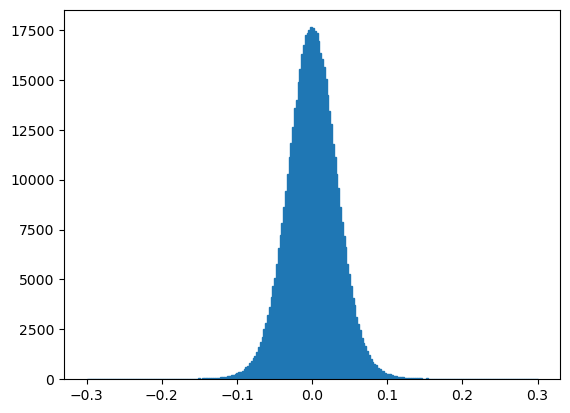

In [45]:
#seeing weight of one layer of the distlled model to say weights cover a small ranger after training
state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

In [46]:
#qunatizing model weights...
zero_point = 0
scale = (weights.max() - weights.min())/(127 - (-128))
(weights/scale + zero_point).clamp(-128,127).round().char()

tensor([[ -5,  -7,   0,  ...,  -6,  -4,   8],
        [  9,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -5,   5,  ...,   0,   6,  -3],
        ...,
        [  5,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -1]], dtype=torch.int8)

In [47]:
#qunatizer per tensor in build function from torch to implement quantization....
dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -7,   0,  ...,  -6,  -4,   8],
        [  9,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -5,   5,  ...,   0,   6,  -3],
        ...,
        [  5,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -1]], dtype=torch.int8)

In [48]:
%%timeit
weights @ weights

7.13 ms ± 959 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
q_fn = QFunctional()

In [50]:
%%timeit
q_fn.mul(quantized_weights,quantized_weights)

192 µs ± 57.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
#ratio of compression rate of weights after quantization....
sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

3.999715196311114

In [53]:
#performing dynamic quantization on distilled model.....
model_ckpt = "gouse-73/distilbert-base-uncased-distilled-clinc"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt).to("cpu"))

#applying quant using function from transformers...
model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

In [54]:
#benchmarking qunatized distilled model with other models we have build.....
pipe = pipeline("text-classification", model=model_quantized,tokenizer=tokenizer)

optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 132.39
Average latency(ms) - 17.44 +/- 1.95 
Accuracy on test set - 0.889


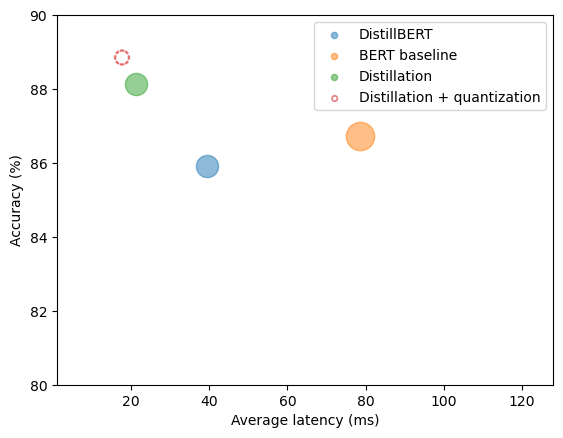

In [55]:
plot_metrics(perf_metrics, optim_type)

### Optimizing it on ONNX Runtime

In [56]:
import os
from psutil import cpu_count

In [57]:
os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

In [58]:
from transformers.convert_graph_to_onnx import convert

model_ckpt = "gouse-73/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")

convert(framework="pt", model=model_ckpt, tokenizer=tokenizer,
output=onnx_model_path, opset=12, pipeline_name="text-classification")

D:\Conda3\Lib\site-packages\transformers\convert_graph_to_onnx.py:379: FutureWarning: The `transformers.convert_graph_to_onnx` package is deprecated and will be removed in version 5 of Transformers
  warnings.warn(


ONNX opset version set to: 12
Loading pipeline (model: gouse-73/distilbert-base-uncased-distilled-clinc, tokenizer: DistilBertTokenizerFast(name_or_path='gouse-73/distilbert-base-uncased-distilled-clinc', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalize

D:\Conda3\Lib\site-packages\transformers\models\distilbert\modeling_distilbert.py:223: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask, torch.tensor(torch.finfo(scores.dtype).min)


================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [59]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession,SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"):
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session


In [60]:
onnx_model = create_model_for_provider(onnx_model_path)

In [61]:
inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

(1, 151)

In [62]:
np.argmax(logits_onnx)

61

In [63]:
clinc_enc["test"][0]["labels"]

61

In [64]:
from scipy.special import softmax
class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy()
            for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [65]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

[{'label': 'car_rental', 'score': 0.9361125}]

In [66]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path
    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [67]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.98
Average latency(ms) - 21.88 +/- 1.81 
Accuracy on test set - 0.881


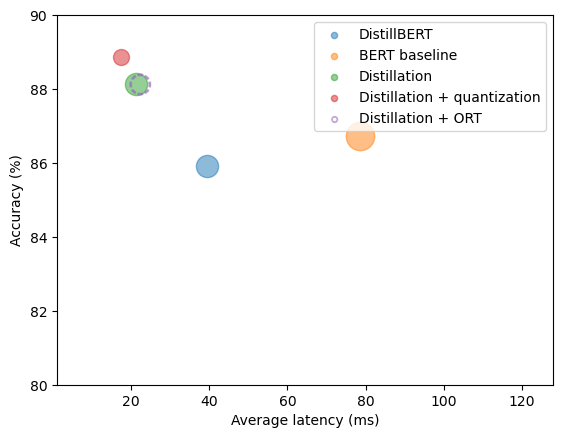

In [68]:
plot_metrics(perf_metrics,optim_type)

In [69]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"

quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.5/attention/MatMul]
Ignore MatM

In [70]:
onnx_quantized_model = create_model_for_provider(model_output)

pipe = OnnxPipeline(onnx_quantized_model, tokenizer)

optim_type = "Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,model_path=model_output)

perf_metrics.update(pb.run_benchmark())

Model size (MB) - 64.36
Average latency(ms) - 7.32 +/- 0.78 
Accuracy on test set - 0.887


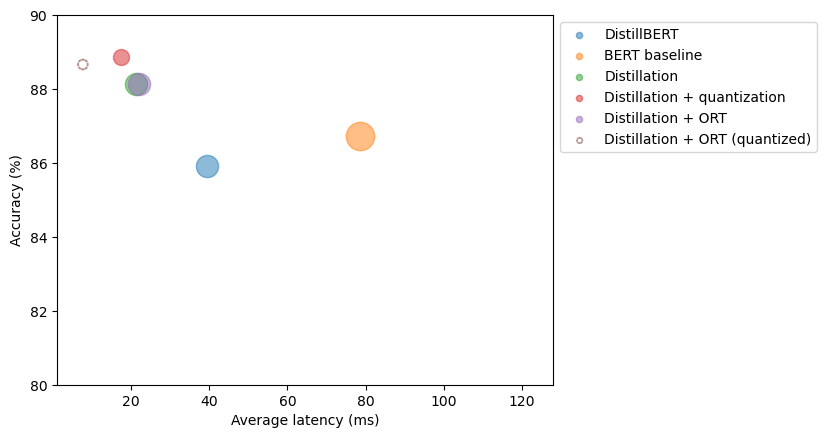

In [71]:
plot_metrics(perf_metrics,optim_type)